Incertezas envolvidas:

$$u_{R_{T}} = u_{ohm}\frac{1}{R_1^2}\sqrt{R_1^2R_2^2 + R_1^2R_{aj}^2 + R_2^2R_{aj}^2}$$
$$u_x = \left|\frac{u_T}{T^2}\right|$$
$$u_y = \left|\frac{u_{R_T}}{R_T}\right|$$

Onde:
- $u_{ohm}$ - incerteza do ohmímetro
- $u_{R_{T}}$ - incerteza da resistência do termistor
- $u_T$ - incerteza do termômetro
- $u_x$ - incerteza de $1/T$
- $u_y$ - incerteza de $\ln(R_T)$

In [2]:
from IPython.display import display
from sympy import init_printing
init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [3]:
# import sympy as sp
import numpy as np
import pandas as pd
import uncertainties.unumpy as unp
from uncertainties import ufloat
from uncertainties.umath import *
from auxiliares import *
from sympy.utilities.lambdify import lambdify
from scipy.odr import Model, RealData, ODR

In [4]:
calib = pd.read_pickle("calib.df")

In [5]:
u_term = combinada(utri(1), uret(0.6))
u_ohm = combinada(uret(2*(0.5 + 0.2)), uret(0.1))
u_r_aj = uret(0.1)
R1 = 99.5
R2 = 100.3

In [6]:
u_r_t = incerteza(parse("R_2*R_aj/R_1")).subs({'uR_2': 'uR', 'uR_1': 'uR'}) #parse("u_R*(R_1**2)/(R_2**2) * sqrt((R_aj**2)/(R_2**2)+(R_aj**2)/(R_1**2)+1)")
u_r_t2 = parse("(R_1**2) / (R_2**2) * sqrt(u_Raj**2 + (1/(R_2**2)+1/(R_1**2)) * R_aj**2 * u_R**2)")
fu_r_t = lambdify('R_aj', u_r_t.subs({'R_1': R1, 'R_2': R2, 'uR': u_ohm, 'uR_aj': u_ohm}))
# fu_r_t2 = lambdify('R_aj', u_r_t2.subs({'R_1': R1, 'R_2': R2, 'u_R': u_ohm, 'u_Raj': u_r_aj}))

In [7]:
# calib["uRt"] = [fu_r_t2(r) for r in calib["Resistência"]]

In [8]:
t = unp.uarray(calib["Temperatura"], calib["uT"])
r = unp.uarray(calib["Resistência"], calib["uRt"])

In [9]:
x = 1/(t+273)
y = unp.log(r)
dcalib = RealData(unp.nominal_values(x), unp.nominal_values(y), sx=unp.std_devs(x), sy=unp.std_devs(y))

In [10]:
mlinear = Model(lambda beta, x: beta[0]*x + beta[1])
myodr = ODR(dcalib, mlinear, beta0=[1., 1.], ndigit=20)

In [11]:
ajuste = myodr.run()
B, lnA = ajuste.beta
uB, ulnA = np.sqrt(np.diag(ajuste.cov_beta))
temperatura = vectorize(lambda raj : ufloat(B,uB)/(log(raj) - ufloat(lnA, ulnA)))
ajuste.pprint()

Beta: [3180.84834594   -6.45805333]
Beta Std Error: [41.58309042  0.13075853]
Beta Covariance: [[ 6.85877932e+02 -2.15392672e+00]
 [-2.15392672e+00  6.78193081e-03]]
Residual Variance: 2.521080397333304
Inverse Condition #: 0.0001604056760319886
Reason(s) for Halting:
  Sum of squares convergence


In [12]:
np.e**(ufloat(lnA, ulnA))

0.0015678448180243471+/-0.00012911590754878462

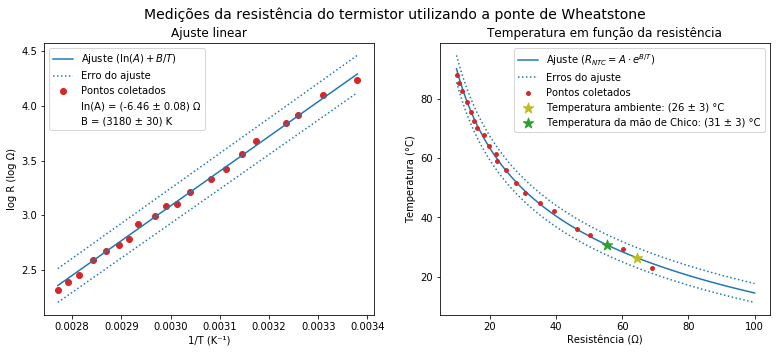

In [56]:
fig = plt.figure(figsize=(14, 5))
fig.suptitle("Medições da resistência do termistor utilizando a ponte de Wheatstone", fontsize=14)
ax = plt.subplot(1, 2, 1)
xs = np.linspace(min(unp.nominal_values(x)), max(unp.nominal_values(x)), 100)
ax.set_xlim(min(xs)*0.99, max(xs)*1.01)
ax.scatter(unp.nominal_values(x), unp.nominal_values(y), c='C3', label='Pontos coletados')
ax.plot(xs, B*xs + lnA, label='Ajuste ($\ln(A) + B/T$)')
ax.plot(xs, (B+uB)*xs + lnA + ulnA, ':', c='C0', label='Erro do ajuste')
ax.plot(xs, (B-uB)*xs + lnA - ulnA, ':', c='C0')
handles, labels = ax.get_legend_handles_labels()

handles.append(Patch(color='none', label=f'ln(A) = {sigdig(lnA, ulnA)} Ω'))
handles.append(Patch(color='none', label=f'B = {sigdig(B, uB)} K'))

ax.set_ylabel("log R (log Ω)")
ax.set_xlabel("1/T (K⁻¹)")
ax.set_title("Ajuste linear")
ax.legend(handles=handles)

ax = plt.subplot(1, 2, 2)
xs = np.linspace(10, 100, 100)
ys = temperatura(xs) - 273
ax.plot(xs, unp.nominal_values(ys), label='Ajuste ($R_{NTC} = A\\cdot e^{B/T}$)', zorder=-1)
ax.plot(xs, unp.nominal_values(ys) + unp.std_devs(ys), ':', c='C0', label='Erros do ajuste')
ax.plot(xs, unp.nominal_values(ys) - unp.std_devs(ys), ':', c='C0')
ax.scatter(calib["Resistência"], calib["Temperatura"], s=15, c='C3', label='Pontos coletados')

rs = [64.5, 55.4]
ts = [temperatura(ufloat(r, u_ohm))-273 for r in rs]

ax.scatter(rs[0], ts[0].n, s=120, c='C8', marker='*', label='Temperatura ambiente: '+sigdig(ts[0].n, ts[0].std_dev)+' °C')
ax.scatter(rs[1], ts[1].n, s=120, c='C2', marker='*', label='Temperatura da mão de Chico: '+sigdig(ts[1].n, ts[1].std_dev)+' °C')

ax.set_ylabel("Temperatura (°C)")
ax.set_xlabel("Resistência (Ω)")
ax.set_title("Temperatura em função da resistência")
ax.legend()

plt.savefig("ponte.png", dpi=400)
plt.show()